<a href="https://colab.research.google.com/github/filizolalab/CADD2021/blob/main/BSR3101_Tutorial_4_2_Simple_regression_models_and_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression and classification models based on fingerprints

*This tutorial is part of the BSR3101 Computer Aided Drug Design, and is based on the [DeepChem tutorials](https://github.com/deepchem/deepchem/tree/master/examples/tutorials). Also check the [DeepChem website](https://deepchem.io/) for other tutorials and documentation.*

### Install and import `deepchem`

To run this tutorial the machine where the calculations are executed must have a copy of the `deepchem` libarary installed. If you're running this on a machine where this is not the case, the library can be installed with the following `pip` command You can of course run this tutorial *locally* if you prefer. In this case, don't run the `pip install` cell since it will download and install Anaconda on your local machine. 


In [1]:
!pip install --pre deepchem
import deepchem as dc
dc.__version__

     |████████████████████████████████| 609 kB 8.1 MB/s 
     |████████████████████████████████| 20.6 MB 109.2 MB/s 


'2.6.0.dev'

We also import `numpy` (for maths), `pandas` (for tables), and `matplotlib` for plotting graphs in the notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Regression on solubility data using ECFP features

A regression problem is a supervised learning problem in which we want to be able to predict continuous quantities based on a featurization of the molecules (e.g. affinity, efficacy, molecular properties, etc.). 

Here, we will see how to predict the *solubility* of small molecules given their 2D chemical structures. Classical approaches to this problem would use semi-empirical calculations to estimate the solubility from physico-chemical principles, but here we want to use a fully knowledge-based approach, starting from a dataset of measured solubilities for real molecules.  

#### Background
Poor drug solubility is one of the main obstacles in the drug discovery and development process and was recently identified to be strongly related to the choice of target explored. ([Bergstrom et al., 2016](https://pubmed.ncbi.nlm.nih.gov/26928657/)) Solubility is the driving force for absorption and acceptable solubility in the intestinal fluid is a prerequisite for achieving sufficiently high drug blood concentrations to obtain a therapeutic effect when systemic effects are warranted. The solubility of a compound affects its absorption, distribution, metabolism, excretion and toxicity (ADMET) profile ([Bergstrom et al., 2018](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5861307/)).


#### Training data
One of the components of DeepChem is [MoleculeNet](https://moleculenet.org/), a diverse collection of chemical and molecular data sets.  For this tutorial, we can use the [Delaney solubility data set](https://pubs.acs.org/doi/10.1021/ci034243x). The property of solubility in this data set is reported in log(solubility) where solubility is measured in moles/liter.


## Load the dataset, featurized with ECFP and split into training, validation, and test sets

In [3]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='ECFP',splitter='scaffold')
train_dataset, valid_dataset, test_dataset = datasets

This dataset contains one single "task", the experimental solubility of the molecules in the dataset. We can check the size of the datasets using the `len` function, that returns the length of an object.

In [4]:
print(tasks)

['measured log solubility in mols per litre']


In [5]:
print(f'training dataset contains {len(train_dataset)} molecules')
print(f'validation dataset contains {len(valid_dataset)} molecules')
print(f'test dataset contains {len(test_dataset)} molecules')

training dataset contains 902 molecules
validation dataset contains 113 molecules
test dataset contains 113 molecules


The `shape` method allows us to inspect the number of rows (i.e. samples, or molecules in our case) and columns (i.e. feature dimension, or fingerpring bits) in the input dataset:

In [ ]:
train_dataset.X.shape

(902, 1024)

We can use the `pandas` library, that we imported with the shortcut name `pd` to visualize the data in a table:

In [6]:
#show a table with the molecule's SMILES and experimental solubility
pd.DataFrame({'id':train_dataset.ids, 
              'solubility':train_dataset.y.flatten()})

,id,solubility
0,CC(C)=CCCC(C)=CC(=O),0.390413
1,CCCC=C,0.090421
2,CCCCCCCCCCCCCC,-2.464346
3,CC(C)Cl,0.704920
4,CCC(C)CO,1.159746
...,...,...
897,CC(=O)OCC(=O)C3(O)CCC4C2CCC1=CC(=O)CCC1(C)C2C(...,-0.649881
898,c3ccc2nc1ccccc1cc2c3,-0.388598
899,Nc2cccc3nc1ccccc1cc23,-0.654719
900,C1CCCCCC1,-0.311180


## Train the model on the train set

To train the model, we specify that we want to execute a regression by selecting the model type `MultitaskRegressor` this allows in principle to fit multiple outputs (multiple "tasks"), but here we only have one (the solubility). we also have to specify the dimension of the input (number of fingerprint bits).

Then we can train the model for 100 epochs: the training will cycle through the training dataset 100 times and optimize the weights in the network.

In [7]:
model = dc.models.MultitaskRegressor(len(tasks), 1024)
model.fit(train_dataset, nb_epoch=100)
#y_pred, y_std = model.predict_uncertainty(test_dataset)

0.06701555728912353

To assess how good is the model we obtained, we calculate an accuracy metric (in this case the Pearson $R^2$ score on the training and the test set. 
To do this we define a metric object, specifying what metric we want to use (`pearson_r2_score`) and evaluate the two datasets. You see that the architecture was able to learn very well the train set, but is not very good in generalizing the results to the test set. This is an indication of overfitting.

The reasons of overfitting could be:
* too simple model, that is not able to capture the essential features of the data
* too simple featurization
* small training set


In [ ]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.9544542968454556}
Test set score: {'pearson_r2_score': 0.2649016902156063}


## Predict solubitliy on the test molecules

Let us look explicitely at the predictions of our model on the test set. We first calculate the prediction in the `test_solubilities` array, and then print out the results in a table:


In [8]:
test_features = test_dataset.X
test_values = test_dataset.y
test_smiles = test_dataset.ids
test_solubilities = model.predict_on_batch(test_features)

pd.DataFrame({
    'id': test_smiles,
    'predicted logS': test_solubilities.flatten(),
    'exp logS': test_values.flatten()
})

,id,predicted logS,exp logS
0,c1cc2ccc3cccc4ccc(c1)c2c34,0.208480,-1.601145
1,Cc1cc(=O)[nH]c(=S)[nH]1,0.407878,0.208483
2,Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4,-0.160346,-0.016027
3,c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45,-1.317137,-2.821917
4,C1=Cc2cccc3cccc1c23,0.304102,-0.528916
...,...,...,...
108,ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl,-0.634986,-1.656304
109,c1ccsc1,0.244367,0.743629
110,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-1.857517,-2.420799
111,Cc1occc1C(=O)Nc2ccccc2,-0.734155,-0.209570


We can use the `matplotlib` library, which we imported with the shortcut name `plt` to plot the predictions agains the actual values.

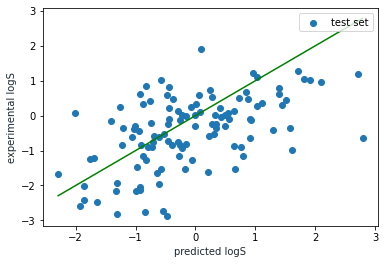

In [9]:
## plot the 
f, ax = plt.subplots()
ax.scatter(test_solubilities, test_values, label='test set')
x = np.array([test_solubilities.min(), test_solubilities.max()])
plt.xlabel('predicted logS', color='#1C2833')
plt.ylabel('experimental logS', color='#1C2833')
plt.plot(x, x, '-g')
plt.legend(loc='upper right');

## Setup deeper model

We used the default choices for the model (e.g. number of layers, and layer size). Most of the time, one needs to explore different options to see which choices give the best results (i.e. the network that is able to generalize better to unseen data).

It's easy to specify different model sizes with the `layer_sizes` argument in the model creation step. Let us try a network with two hidden layers of 128 nodes each.

In [10]:
model = dc.models.MultitaskRegressor(len(tasks), 1024, layer_sizes=[128,128])
model.fit(train_dataset, nb_epoch=100)
#y_pred, y_std = model.predict_uncertainty(test_dataset)

0.07689337730407715

In [11]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.9621514131425742}
Test set score: {'pearson_r2_score': 0.4129457034667006}


In [ ]:
model = dc.models.MultitaskRegressor(len(tasks), 1024, layer_sizes=[512,512])
model.fit(train_dataset, nb_epoch=100)
#y_pred, y_std = model.predict_uncertainty(test_dataset)

0.07719830989837646

In [ ]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.954967992913526}
Test set score: {'pearson_r2_score': 0.39769262694909985}


This is better than what we had with the default settings. Can we do a more thorough search of the optimal parameters?

## Hyper-parameter search

It's easy to setup a search in parameter space. We can specify the options we want for the number of layers, their size, the dropout probability, the learning rate, etc. and train all the models, then we select the one that gives the best accuracy on hte test set.
We use the `GridHyperparamOpt` optimizer for this:

In [20]:
params_dict = {
    'n_tasks': [len(tasks)],
    'n_features': [1024],
    'layer_sizes': [[500], [500,500], [1000]],
    'dropouts': [0.2, 0.5],
    'learning_rate': [0.001, 0.0002]
}
optimizer = dc.hyper.GridHyperparamOpt(dc.models.MultitaskRegressor)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
        params_dict, train_dataset, valid_dataset, metric, transformers)

In [21]:
all_results

{'_dropouts_0.200000_layer_sizes[1000]_learning_rate_0.000200_n_features_1024_n_tasks_1': 0.40360147366334165,
 '_dropouts_0.200000_layer_sizes[1000]_learning_rate_0.001000_n_features_1024_n_tasks_1': 0.2652749916056386,
 '_dropouts_0.200000_layer_sizes[500, 500]_learning_rate_0.000200_n_features_1024_n_tasks_1': 0.337674332833493,
 '_dropouts_0.200000_layer_sizes[500, 500]_learning_rate_0.001000_n_features_1024_n_tasks_1': 0.3710468828157778,
 '_dropouts_0.200000_layer_sizes[500]_learning_rate_0.000200_n_features_1024_n_tasks_1': 0.3549405931337012,
 '_dropouts_0.200000_layer_sizes[500]_learning_rate_0.001000_n_features_1024_n_tasks_1': 0.33013076660140317,
 '_dropouts_0.500000_layer_sizes[1000]_learning_rate_0.000200_n_features_1024_n_tasks_1': 0.3872875507265269,
 '_dropouts_0.500000_layer_sizes[1000]_learning_rate_0.001000_n_features_1024_n_tasks_1': 0.34029643552442435,
 '_dropouts_0.500000_layer_sizes[500, 500]_learning_rate_0.000200_n_features_1024_n_tasks_1': 0.3078715713822101

It seems that `layer_sizes=[1000], dropouts=0.2, learning_rate=0.0002` gives the best $R^2_{test}$. But how long should we train the network for?

In [22]:
model = dc.models.MultitaskRegressor(len(tasks), 1024, layer_sizes=[1000], dropouts=0.2, learning_rate=0.0002)
model.fit(train_dataset, nb_epoch=100)
#y_pred, y_std = model.predict_uncertainty(test_dataset)

0.13043015480041503

## Early stopping

Training longer does not automatically result in better models: longer optimization on the training set can serult in overfitting. 

The standard procedure to determine at what point we should stop the training (i.e. how to decide how many epochs to train for) is to look at the value of the accuracy on the test validation set during the training. we can instruct the trainer to print out the value of the $R^2_{test}$ with the `ValidationCallback` function.

Here we ask the $R^2_{test}$ to be printed every 10 steps. 

In [23]:
model = dc.models.MultitaskRegressor(n_tasks=len(tasks),n_features=1024,layer_sizes=[1000], dropouts=0.2, learning_rate=0.0002)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
callback = dc.models.ValidationCallback(valid_dataset, 10, metric)
vf=model.fit(train_dataset, nb_epoch=50, callbacks=callback)

Step 10 validation: pearson_r2_score=0.181829
Step 20 validation: pearson_r2_score=0.237051
Step 30 validation: pearson_r2_score=0.296834
Step 40 validation: pearson_r2_score=0.328729
Step 50 validation: pearson_r2_score=0.353702
Step 60 validation: pearson_r2_score=0.350189
Step 70 validation: pearson_r2_score=0.35708
Step 80 validation: pearson_r2_score=0.360121
Step 90 validation: pearson_r2_score=0.362771
Step 100 validation: pearson_r2_score=0.377367
Step 110 validation: pearson_r2_score=0.389945
Step 120 validation: pearson_r2_score=0.388819
Step 130 validation: pearson_r2_score=0.383078
Step 140 validation: pearson_r2_score=0.381423
Step 150 validation: pearson_r2_score=0.378966
Step 160 validation: pearson_r2_score=0.369246
Step 170 validation: pearson_r2_score=0.364459
Step 180 validation: pearson_r2_score=0.361096
Step 190 validation: pearson_r2_score=0.356119
Step 200 validation: pearson_r2_score=0.352186
Step 210 validation: pearson_r2_score=0.353111
Step 220 validation: pe

Another option to reduce the risk of overfitting is to gradually reduce the learning rate. Instead of using a constant value for the `learning_rate` argument in the model definition, we can use the `ExponentialDecay` function: in this case we start with 

In [25]:
learning_rate_sc = dc.models.optimizers.ExponentialDecay(0.0002, 0.9, 1000)
model = dc.models.MultitaskRegressor(n_tasks=len(tasks),n_features=1024,layer_sizes=[1000],dropouts=0.2,learning_rate=learning_rate_sc)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
callback = dc.models.ValidationCallback(valid_dataset, 20, metric)
vf=model.fit(train_dataset, nb_epoch=50, callbacks=callback)

Step 20 validation: pearson_r2_score=0.230349
Step 40 validation: pearson_r2_score=0.342484
Step 60 validation: pearson_r2_score=0.368868
Step 80 validation: pearson_r2_score=0.383355
Step 100 validation: pearson_r2_score=0.378193
Step 120 validation: pearson_r2_score=0.384679
Step 140 validation: pearson_r2_score=0.384569
Step 160 validation: pearson_r2_score=0.375793
Step 180 validation: pearson_r2_score=0.377034
Step 200 validation: pearson_r2_score=0.365436
Step 220 validation: pearson_r2_score=0.358681
Step 240 validation: pearson_r2_score=0.336782
Step 260 validation: pearson_r2_score=0.339283
Step 280 validation: pearson_r2_score=0.327344
Step 300 validation: pearson_r2_score=0.319278
Step 320 validation: pearson_r2_score=0.314849
Step 340 validation: pearson_r2_score=0.306088
Step 360 validation: pearson_r2_score=0.292598
Step 380 validation: pearson_r2_score=0.297604
Step 400 validation: pearson_r2_score=0.28994
Step 420 validation: pearson_r2_score=0.283161
Step 440 validatio


A shorter training gives better generalization


In [33]:
model = dc.models.MultitaskRegressor(n_tasks=len(tasks),n_features=1024,layer_sizes=[1000],dropouts=0.2,learning_rate=learning_rate_sc)
vf=model.fit(train_dataset, nb_epoch=20)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.824471998102623}
Test set score: {'pearson_r2_score': 0.4472464555554748}




## Estimating uncertainty


How can we estimate uncertainty in our predictions? 
A nice approach is to 

In [65]:
model = dc.models.MultitaskRegressor(
    n_tasks=len(tasks),
    n_features=1024,
    layer_sizes=[1000],
    dropouts=0.2,
    learning_rate=learning_rate_sc,
    uncertainty=True)

model.fit(train_dataset, nb_epoch=10)
y_pred, y_std = model.predict_uncertainty(test_dataset)

The returned objects `y_pred` and `y_std` contain the predictions of the solubility and of its standard deviation. We canprint them in a table together with the actual observed value:

In [66]:

results_uncertainty = pd.DataFrame({
    'id': test_dataset.ids.tolist(),
    'predicted_logS': y_pred.flatten(),
    'predicted_std': y_std.flatten(),
    'exp_logS': test_dataset.y.flatten(),
    'abs_error': np.abs(y_pred.flatten()-test_dataset.y.flatten())
})

results_uncertainty.head()

,id,predicted_logS,predicted_std,exp_logS,abs_error
0,c1cc2ccc3cccc4ccc(c1)c2c34,-0.209119,0.820495,-1.601145,1.392026
1,Cc1cc(=O)[nH]c(=S)[nH]1,0.095314,0.690065,0.208483,0.113168
2,Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4,-0.026607,0.654205,-0.016027,0.010579
3,c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45,-1.473659,0.836357,-2.821917,1.348258
4,C1=Cc2cccc3cccc1c23,-0.318074,0.720315,-0.528916,0.210842


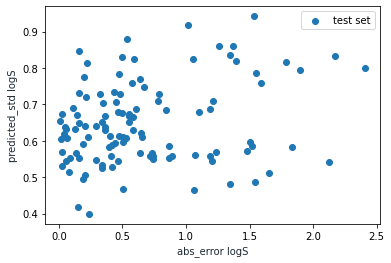

In [67]:

f, ax = plt.subplots()
ax.scatter(results_uncertainty.abs_error,results_uncertainty.predicted_std, label='test set')
plt.xlabel('abs_error logS', color='#1C2833')
plt.ylabel('predicted_std logS', color='#1C2833')
#plt.plot(x, x, '-g')
plt.legend(loc='upper right');


The overall size of the predicted error is slightly smaller than the observed one, but 

Now let's see how well the values satisfy the expected distribution. If the standard deviations are correct, and if the errors are normally distributed (which is certainly not guaranteed to be true!), we expect 95% of the values to be within two standard deviations, and 99% to be within three standard deviations. Here is a histogram of errors as measured in standard deviations.


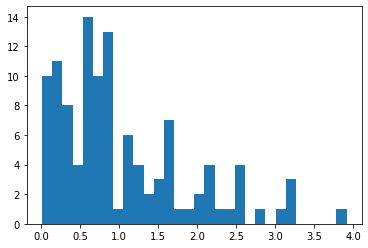

In [68]:
plt.hist(results_uncertainty.abs_error/results_uncertainty.predicted_std, 30)
plt.show()

In [69]:
total_points = len(results_uncertainty.predicted_std)
sum(results_uncertainty.abs_error/results_uncertainty.predicted_std<2)/total_points

0.8495575221238938

In [70]:
sum(results_uncertainty.abs_error/results_uncertainty.predicted_std<3)/total_points

0.9557522123893806

## Classifier on Tox21 data using ECFP fingerprints

Let us see how what we've seen so far can be appliet to classification tasks. We will use the `tox21` dataset. 

#### Training data
The NIH “[Toxicology in the 21st Century](https://ncats.nih.gov/tox21)” (Tox21) initiative created a public database measuring toxicity of compounds, which has been used in the 2014 Tox21 Data Challenge. This dataset contains qualitative toxicity measurements for 8k compounds on 12 different targets. The raw data csv file contains columns below:

* `smiles` - SMILES representation of the molecular structure
* `NR-XXX` - Nuclear receptor signaling bioassays results
* `SR-XXX` - Stress response bioassays results





In [80]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP')
train_dataset, valid_dataset, test_dataset = datasets

In [81]:
print(f'training dataset contains {len(train_dataset)} molecules')
print(f'validation dataset contains {len(valid_dataset)} molecules')
print(f'test dataset contains {len(test_dataset)} molecules')

training dataset contains 6264 molecules
validation dataset contains 783 molecules
test dataset contains 784 molecules


In [75]:
pd.DataFrame(train_dataset.y, columns=tasks)

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


`MultitaskClassifier` is a simple stack of fully connected layers (similar to the `MultitaskRegressor` we used above). In this example we tell it to use a single hidden layer of width 1000. We also tell it that each input will have 1024 features, and that it should produce predictions for 12 different tasks.

In [84]:
model = dc.models.MultitaskClassifier(n_tasks=12, n_features=1024, layer_sizes=[1000])
model.fit(train_dataset, nb_epoch=20)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric], transformers))
print('test set score:', model.evaluate(test_dataset, [metric], transformers))

training set score: {'roc_auc_score': 0.9753624674979134}
test set score: {'roc_auc_score': 0.6728614515289147}
